In [153]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from tqdm import tqdm

dt = 0.1    # update time scale (ms)


#==============================================================================#
#========================= !All needed to be defined! =========================#

                           # Populations properties #
class Population:
    NN       =     np.array([490, 490, 20])             # neuron numbers
    #NN       =     np.array([20,20,2])                    # neuron numbers
    Tag      =     {"dSPN":0, "iSPN":1, "FSI":2}        # labels 
    Name     =     {0:"dSPN", 1:"iSPN", 2:"FSI"}
    Colors   =     np.array([[0, 0, 1],
                             [0, 1, 0],
                             [1, 0, 0]])                # colors for plots
    size = len(Population.NN)

    # connectivity parameters of populations
    CP       =     np.array([[0.26, 0.27, 0.53], 
                             [0.06, 0.36, 0.36], 
                             [0, 0, 0.58]])             # connectivity probabilities
    CW       =     np.array([[-0.4, -1.3, -5], 
                             [-1.1, -1.1, -5], 
                             [0, 0, -0.6]])             # connectivity weigths (pA/Hz)
                                                        # negative is inhibitory

    # single neuron parameters of populations
    Tau      =     np.array([10, 10, 10])               # time constants (ms)
    Thr      =     np.array([200, 200, 80])             # thresholds (pA)
    Beta     =     np.array([0.1, 0.1, 1])              # gains (Hz/pA)
    
    # synaptic parameters
    Tausyn   =     10                                   # synaptic time constants (ms)
    
    # LIF parameters
    Vthr     =     np.array([-50, -50, -50])            # threshold voltage (mv)
    Vreset   =     np.array([-80, -80, -80])            # reset voltage (mv)
    Vrest    =     np.array([-70, -70, -70])            # rest voltage (mv)
    Vspike   =     np.array([40, 40, 40])               # spike voltage (mv)
    Ix       =     np.array([30, 30, 40])               # external inputs (mv)
#==============================================================================#



#==============================================================================#
                      # Connectivity Matrix (Weighted) #

def create_Wmat(NN, CP, CW):
    """
    returns a random weighted connectivity matrix of several 
    neuronal populations with 'NN' as list of neuron population
    numbers, 'CP' as connectivity probability matrix and 'CW'
    as connectivity weight matrix on the population level.
    
    Examples are: 
    NN = np.array([490, 490, 20])
    CP = np.array([[0.26, 0.27, 0.53], 
                  [0.06, 0.36, 0.36], 
                  [0, 0, 0.58]]) 
    CW = np.array([[-0.4, -1.3, -5], 
                  [-1.1, -1.1, -5], 
                  [0, 0, -0.6]])  #inhibitory
    """
    nntotal = np.sum(NN) # total number of neurons
    npopulation = len(NN) # number of populations 
    
    
    Wmat = np.array([]) 
    for ind1 in range(npopulation):        
        Rowblock = np.array([])
        for ind2 in range(npopulation):
            # creating weighted connectivity matrix block 
            # of population ind2 to ind1  
            w = CW[ind1, ind2]
            Size = (NN[ind1], NN[ind2]) 
            Prob = [CP[ind1, ind2], 1-CP[ind1, ind2]] # connection probability
            Block = np.random.choice([1, 0], Size, p=Prob)*w # individual block
            Rowblock = np.concatenate((Rowblock, Block), axis=1) if Rowblock.size else Block
        Wmat = np.concatenate((Wmat, Rowblock), axis=0) if Wmat.size else Rowblock
    
    return(Wmat)


#==============================================================================#
                              # Neuron Properties #
class Neuron:
    Tag     =     np.array([i for i in range(Population.NN.size) for j in range(Population.NN[i])]) # Neuron tag
    Colors  =     np.array([Population.Colors[i] for i in Tag])    # colors for plots
    Time    =     []
    
    Tau     =     np.array([Population.Tau[i] for i in Tag])       # single neuron time constant (ms)
    Thr     =     np.array([Population.Tau[i] for i in Tag])       # threshold of transfer function (pA)
    Beta    =     np.array([Population.Beta[i] for i in Tag])      # gain of transfer function (Hz/pA)
    
    Vthr    =     np.array([Population.Vthr[i] for i in Tag])      # single neuron threshold potential in LIF
    Vreset  =     np.array([Population.Vreset[i] for i in Tag])    # single neuron reset potential in LIF
    Vrest   =     np.array([Population.Vrest[i] for i in Tag])     # single neuron rest potential in LIF
    Vspike  =     np.array([Population.Vspike[i] for i in Tag])    # single neuron spike potential in LIF
    
    Wmat    =     create_Wmat(Population.NN, Population.CP, Population.CW)  # weighted connectivity matrix
    Cmat    =     np.where(Wmat!=0, 1, 0)                                   # connectivity matrix
    
    # initial conditions
    V       =     np.array([Population.Vrest[i] for i in Tag])   # initial conditions [at rest] (mv)
    Spike   =     np.zeros(Tag.size, dtype=bool)                 # spike train array [boolean]
    Isyn    =     np.zeros(Tag.size)                             # synaptic input (mv)
    
    
    Ix      =     np.array([Population.Ix[i] for i in Tag])      # external input (mv)
    




#==============================================================================#
                                  # Dynamics #

#### single neuron model (V to Spike)
#### Leaky integrate and fire
def update_spikes(v, i_syn, v_thr, v_reset, v_rest, tau):
    global dt
    spike = False
    if v>v_thr:
        spike = True
        v = v_reset
    else:
        dv = ((v_rest-v) + i_syn)*dt/tau
        v += dv
    return spike, v

vupdate_spikes = np.vectorize(update_spikes)

def update_Spikes():
    global Neuron
    (Neuron.Spike, Neuron.V) = vupdate_spikes(Neuron.V, Neuron.Isyn+Neuron.Ix, Neuron.Vthr, Neuron.Vreset, Neuron.Vrest, Neuron.Tau)



#### Connectivity (Spike to Isyn) ####
#### Using connectivity matrix updates V and returns Spike ####
def update_Inputs():
    global Neuron
    I_in = np.matmul(Neuron.Wmat, Neuron.Spike*1)/dt # normalized such that it is a delta function
    dI_syn = (-Neuron.Isyn + I_in)/Population.Tausyn * dt
    Neuron.Isyn += dI_syn

    

    
#### Updating all neurons ####
def update_Neurons():
    '''
    updates neurons voltages 'V' and spikes produced 'Spike' of 'Neuron' class.
    The update is in time interval 'dt' that should be defined outside the function.
    '''
    update_Inputs()
    update_Spikes()

    
    
#### run simulation ####    
def rundynamics(endtime, monitor_ind):
    '''
    runs a simulation of 'Neuron' with initial voltages 'V' in 'Neuron' 
    (which is a numpy array with a size of neuronnumbers), 'endtime' 
    as the final time in ms, and 'monitor_ind' as a list of indices 
    for which the spikes and voltages are recorded.
    '''
    global Neuron
    iterations = round(endtime/dt)+1
    Neuron.Time = np.linspace(0, endtime, iterations) # time array
    monitorsize = len(monitor_ind)
    monitorV = np.zeros((monitorsize, iterations))
    monitorSpike = np.zeros((monitorsize, iterations), dtype=bool)
    monitorSpiketime = [0]*monitorsize
    Vspikemonitored = Neuron.Vspike[monitor_ind]
    spikeMean = np.zeros((Population.size, iterations))
    
    for ind in tqdm(range(iterations)):
        update_Neurons()
        monitorV[:, ind] = Neuron.V[monitor_ind]  # monitoring volatage
        Spiked = Neuron.Spike[monitor_ind]   # boolean array of spike for monitored neurons  
        monitorSpike[:, ind] = Spiked  # monitoring spike
        monitorV[Spiked, ind-1] = Vspikemonitored[Spiked] # setting spike voltage for those spiked
        # average spike activities of populations
        spike_mean = [np.mean(Neuron.Spike[Neuron.Tag==i]*1) for i in range(Population.size)]
        spikeMean[:, ind] = np.divide(spike_mean, dt)  # normalizing to get density
        
        
    for ind in range(monitorsize):
        monitorSpiketime[ind] = Neuron.Time[monitorSpike[ind, :]] 
            
    return monitorSpiketime, monitorSpike, monitorV, spikeMean

#==============================================================================#
                                  # Plots #

def rasterplot(monitorSpiketime, monitor_ind):
    colors = Neuron.Colors[monitor_ind]
    yticks = np.arange(len(monitor_ind))
    
    fig, axs = plt.subplots(1,1)
    axs.eventplot(monitorSpiketime, colors=colors, linelengths = 0.9)
    #plt.yticks(yticks, monitor_ind)
    plt.xlabel('time (ms)')
    plt.ylabel('neuron no.')
    
    custom_lines = [Line2D([0], [0], color=Population.Colors[ind], lw=4) for ind in range(Population.size)]
    axs.legend(custom_lines, Population.Tag, bbox_to_anchor=(0., 1.0, 1., .10), loc=3,ncol=3, mode="expand", borderaxespad=0.)
    plt.show()

def meanplot(spikeMean, Time):
    fig, axs = plt.subplots(1,1)
    for i, color in enumerate(Population.Colors):
        plt.plot(Time, spikeMean[i, :], color=color)
    plt.xlabel('time (ms)')
    plt.ylabel('mean spike density of populations (1/s)')
    custom_lines = [Line2D([0], [0], color=Population.Colors[ind], lw=4) for ind in range(Population.size)]
    axs.legend(custom_lines, Population.Tag, bbox_to_anchor=(0., 1.0, 1., .10), loc=3,ncol=3, mode="expand", borderaxespad=0.)
    plt.show()   

        
#==============================================================================#
                                  # Final #
        
def run_plot(endtime, monitor_ind):
    iterations = round(endtime/dt)+1
    Time = np.linspace(0, endtime, iterations) # time array
    (monitorSpiketime, monitorSpike, monitorV, spikeMean) = rundynamics(endtime, monitor_ind)
    rasterplot(monitorSpiketime, monitor_ind)
    meanplot(spikeMean, Time)

100%|█████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:01<00:00, 646.18it/s]


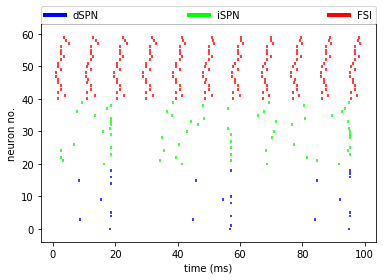

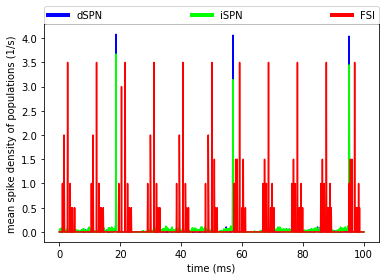

In [163]:
monnum = 20
nnum = np.cumsum(Population.NN)
monitor_ind = np.concatenate((range(monnum), range(nnum[0],nnum[0]+monnum), range(nnum[1],nnum[1]+monnum)))
run_plot(100, monitor_ind)

array([  0. ,   0.1,   0.2, ...,  99.8,  99.9, 100. ])